# Increasing precision
## data augmentation
- flip
- move
- blur
- brighten/darken

## network
hyperparam opt - nb Couches conv, taille filtres

## decrease false positive
increase weight of negatives

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
home = "C:/Users/joanc/PycharmProjects/face_detection/dataset/start_deep/"

## Loading data

In [3]:
df = pd.read_csv(f"{home}posneg.txt", sep=" ", names=["filename", "class"])
df = df.astype(str)
df.head()

,filename,class
0,1/Image000605.pgm,1
1,1/Image000607.pgm,1
2,1/Image000608.pgm,1
3,1/Image000609.pgm,1
4,1/Image000610.pgm,1


In [4]:
df_test = pd.read_csv("dataset/start_deep/testposneg.txt", sep=" ", names=["filename", "class"])
df_test = df_test.astype(str)
df_test.head()

,filename,class
0,"test_images/googlefaces_test/503_1__t0,0_r0_s1...",1
1,"test_images/googlefaces_test/367_0__t0,0_r0_s1...",1
2,"test_images/googlefaces_test/10_0__t0,0_r0_s1.pgm",1
3,"test_images/googlefaces_test/53_0__t0,0_r0_s1.pgm",1
4,"test_images/googlefaces_test/323_0__t0,0_r0_s1...",1


In [5]:
# Changing files from pgm to jpg - run only once
# from PIL import Image
# for file in df_test["filename"]:
#     abs_path = home+file
#     img = Image.open(abs_path)
#     new_name = abs_path.replace(".pgm", ".jpg")
#     if new_name != abs_path:
#         img.save(new_name)

In [6]:
# from PIL import Image
# for file in df["filename"]:
#     abs_path = home+"train_images/" + file
#     img = Image.open(home+"train_images/" + file)
#     new_name = abs_path.replace(".pgm", ".jpg")
#     img.save(new_name)

In [7]:
# renaming .pgm to jpg
def replace_name(name):
    return name.replace(".pgm", ".jpg")
df["filename"] = df["filename"].apply(replace_name)
df_test["filename"] = df_test["filename"].apply(replace_name)

In [8]:
df.head()

,filename,class
0,1/Image000605.jpg,1
1,1/Image000607.jpg,1
2,1/Image000608.jpg,1
3,1/Image000609.jpg,1
4,1/Image000610.jpg,1


### Split train and validation

In [9]:
from sklearn.model_selection import train_test_split

df_train = df
df_val, df_test = train_test_split(df_test, train_size=0.5, random_state=1)

In [10]:
root_dir = home+"train_images/"

In [11]:
from PIL import Image
img = Image.open(root_dir+df["filename"][0])
IMG_HEIGHT, IMG_WIDTH = img.height, img.width
IMG_HEIGHT, IMG_WIDTH

(36, 36)

## Adding weigths based on label

In [12]:
labels, counts = np.unique(df_train["class"], return_counts=True)
weights_labels = {it:(np.sum(counts) / (counts[it]*len(labels))) for it in range(len(labels))}
weights_labels

{0: 1.701669758812616, 1: 0.708043847460244}

In [13]:
batch_size=32
train_image_generator = ImageDataGenerator(rescale=1./255,
#                                                   vertical_flip=True,
                                                          width_shift_range=[-4,4],
                                                          height_shift_range=[-4,4],
                                                          horizontal_flip=True,
                                                          rotation_range=5,
                                                          shear_range=0.2,
                                                          zoom_range=0.2,
                                                          brightness_range=[0.8,1.0],
                                            )
train_data_gen = train_image_generator.flow_from_dataframe(df_train, 
                                                           directory=root_dir,
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=True)

Found 91720 validated image filenames belonging to 2 classes.


In [14]:
batch_size=32
val_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = val_image_generator.flow_from_dataframe(df_val, 
                                                           directory=home,
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=False)

Found 3814 validated image filenames belonging to 2 classes.


In [15]:
test_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_generator.flow_from_dataframe(df_test, 
                                                           directory=home,
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=False)

Found 3814 validated image filenames belonging to 2 classes.


In [16]:
sample_training_images, labels = next(train_data_gen)

In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img[:,:,0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

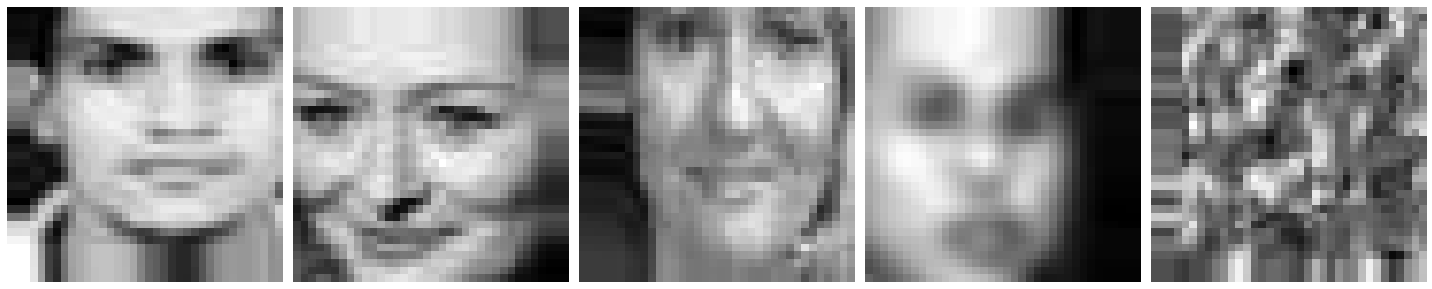

In [18]:
plotImages(sample_training_images[:5])

In [19]:
# bugg fix for some computers
# it makes tensorflow use only the part of the gpu that is needed
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [20]:
dropout_rate = 0.5
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
    MaxPooling2D(),
    Dropout(dropout_rate),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(dropout_rate),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

In [21]:
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    auc = tf.metrics.AUC(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam',
              loss="binary_crossentropy", 
             metrics=["accuracy","AUC"])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 36, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          1

## Finding learning rate

In [23]:
# from lr_finder import LRFinder

# lr_finder = LRFinder()
# _ = model.fit_generator(train_data_gen, epochs=1, callbacks=[lr_finder], verbose=False)
# lr_finder.plot()

## Training

In [24]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=None,
    epochs=epochs,
    validation_data=val_data_gen,
    callbacks=[early_stopping],
    class_weight=weights_labels
#     validation_steps=len(df) // batch_size
)

Epoch 1/100
2867/2867 [==============================] - 113s 39ms/step - loss: 0.2617 - accuracy: 0.8853 - AUC: 0.9580 - val_loss: 0.0519 - val_accuracy: 0.9845 - val_AUC: 0.9926
Epoch 2/100
2867/2867 [==============================] - 109s 38ms/step - loss: 0.1169 - accuracy: 0.9546 - AUC: 0.9912 - val_loss: 0.0454 - val_accuracy: 0.9874 - val_AUC: 0.9979
Epoch 3/100
2867/2867 [==============================] - 108s 38ms/step - loss: 0.0857 - accuracy: 0.9679 - AUC: 0.9950 - val_loss: 0.0333 - val_accuracy: 0.9900 - val_AUC: 0.9972
Epoch 4/100
2867/2867 [==============================] - 114s 40ms/step - loss: 0.0751 - accuracy: 0.9715 - AUC: 0.9959 - val_loss: 0.0311 - val_accuracy: 0.9934 - val_AUC: 0.9974
Epoch 5/100
2867/2867 [==============================] - 106s 37ms/step - loss: 0.0656 - accuracy: 0.9751 - AUC: 0.9968 - val_loss: 0.0288 - val_accuracy: 0.9919 - val_AUC: 0.9975
Epoch 6/100
2867/2867 [==============================] - 113s 39ms/step - loss: 0.0625 - accuracy: 0

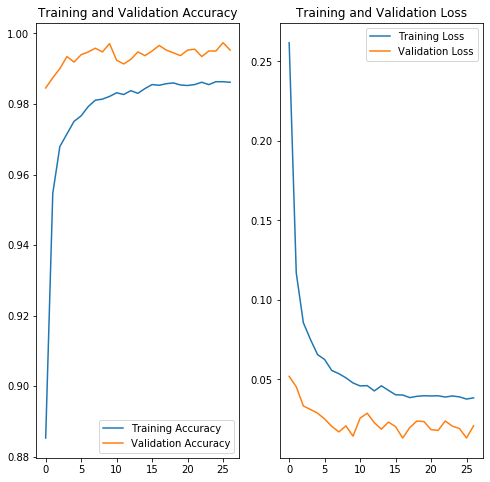

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Metrics

In [26]:
truth = val_data_gen.labels
prediction = model.predict_generator(val_data_gen, workers=0)

In [27]:
from sklearn.metrics import roc_auc_score, accuracy_score

print(roc_auc_score(truth, prediction))
print(accuracy_score(truth, np.round(prediction)))

0.9969347428793554
0.995280545359203


# Results

Best val_loss: 0.0209 - val_accuracy: 0.9953 - val_AUC: 0.9969


[9, 9]


C:\Users\joanc\PycharmProjects\face_detection\confusion_matrix.py:166: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\joanc\PycharmProjects\face_detection\confusion_matrix.py:167: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
C:\Users\joanc\PycharmProjects\face_detection\confusion_matrix.py:169: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\joanc\PycharmProjects\face_detection\confusion_matrix.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


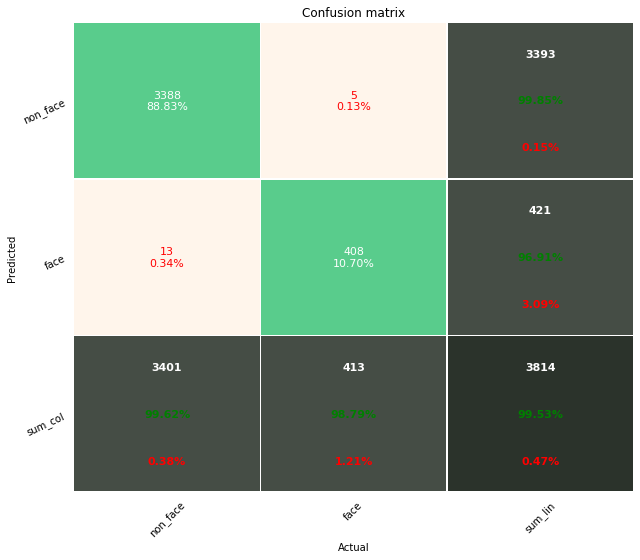

In [28]:
import confusion_matrix

confusion_matrix.plot_confusion_matrix_from_data(truth, np.round(prediction)[:,0], cmap="Oranges", figsize=[9,9], columns=["non_face", "face"])